In [115]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


In [116]:
test = pandas.read_csv("data/nba_teste.csv")
train = pandas.read_csv("data/nba_treino.csv")

In [117]:
train_X = train.drop(['TARGET_5Yrs'], axis=1)
test_X = test.drop(['TARGET_5Yrs'], axis=1)

train_y = train['TARGET_5Yrs']
test_y = test['TARGET_5Yrs']

In [118]:
test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3PMade,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,40,6.7,3.6,1.2,3.0,39.8,0.1,0.6,13.6,1.1,1.5,77.6,0.5,0.8,1.2,0.4,0.3,0.1,0.6,1
1,27,6.6,1.3,0.6,1.3,47.2,0.0,0.0,0.0,0.1,0.3,28.6,0.6,1.4,2.0,0.2,0.2,0.6,0.3,1
2,44,6.4,2.4,1.0,1.9,53.7,0.0,0.0,0.0,0.4,0.7,50.0,0.4,1.0,1.4,0.2,0.2,0.4,0.6,1
3,49,5.3,2.1,0.7,1.9,37.6,0.0,0.0,0.0,0.7,1.1,64.2,0.5,0.7,1.2,0.2,0.3,0.2,0.5,0
4,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,4.1,5.0,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,1


# Aprendizado supervisionado
## K Nearest Neighbors (KNN)
O KNN é uma técnica de aprendizado supervisionado que se baseia na proximidade entre os dados para realizar a regressão ou classificação. Ele é um algoritmo simples, do tipo "lazy", ou seja, não realiza nenhum tipo de treinamento nem induz modelo, apenas armazena os dados e os utiliza para realizar as predições.

Seu funcionamento é direto e objetivo: de posse de um conjunto de informações de treinamento, o algoritmo armazena todas as suas respectivas classes ou valores associados. Quando uma entrada de teste é recebida, a distância entre esse novo dado e todos os demais de treinamento é calculada. Os K vizinhos mais próximos são selecionados e a categoria mais frequente entre eles - obtida pela moda no caso da classificação - é atribuída ao novo valor. Quando se trata de regressões, é possível obter a variável contínua através de uma medida de tendência central, como a média ou a mediana das labels pertencentes aos vizinhos.

### A importância de K
O valor de K é um parâmetro que deve ser definido considerando as particularidades de cada dataset. Ele é responsável por definir a quantidade de vizinhos que serão considerados para a classificação ou regressão. Um valor muito baixo pode levar a um overfitting, enquanto um valor muito alto pode levar a um underfitting.


In [119]:
def knn(k, train, test):
    """
    Calculates the k nearest neighbors of a test sample in a train set.

    Parameters
    ----------
    k : int
        Number of neighbors to consider.
    train : numpy.ndarray
        Train set.
    test : numpy.ndarray
        Test sample.

    Returns
    -------
    numpy.ndarray
        Indices of the k nearest neighbors of test in train.
    """
    dist = np.sqrt(np.sum((train - test) ** 2, axis=1))  # Euclidean distance
    dist_sorted = np.argsort(dist)
    return dist_sorted[:k]

In [120]:
def classify_knn(k, train, test, train_y):
    """
    Classifies a test sample based on the k nearest neighbors in a train set.

    Parameters
    ----------
    k : int
        Number of neighbors to consider.
    train : numpy.ndarray
        Train set.
    test : numpy.ndarray
        Test sample.
    train_y : numpy.ndarray
        Labels of the train set.

    Returns
    -------
    list
        Classifications of the test samples.
    """
    neighbours = [knn(k, train, test.iloc[i]) for i in range(len(test_X))]
    predictions = [train_y[neighbours[i]] for i in range(len(neighbours))]
    return [scipy.stats.mode(predictions[i], keepdims=True)[0][0] for i in range(len(predictions))]


In [121]:
def obtain_metrics(predictions, test_y):
    """
    Calculates the accuracy, precision, recall and f1-score of a classification.

    Parameters
    ----------
    predictions : numpy.ndarray
        predictions of the test set.
    test_y : numpy.ndarray
        Labels of the test set.

    Returns
    -------
    tuple
        Accuracy, precision, recall and f1-score of the prediction.
    """
    tp = sum([tag == test == 1 for tag, test in zip(predictions, test_y)])
    tn = sum([tag == test == 0 for tag, test in zip(predictions, test_y)])
    fp = sum([1 for i in range(len(predictions)) if predictions[i] == 1 and test_y.iloc[i] == 0])
    fn = sum([1 for i in range(len(predictions)) if predictions[i] == 0 and test_y.iloc[i] == 1])
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [122]:
def confusion_matrix(predictions, test_y):
    """
    Calculates the confusion matrix of a classification.

    Parameters
    ----------
    predictions : numpy.ndarray
        predictions of the test set.
    test_y : numpy.ndarray
        Labels of the test set.

    Returns
    -------
    tuple
        Accuracy, precision, recall and f1-score of the classification.
    """
    tp = sum([tag == test == 1 for tag, test in zip(predictions, test_y)])
    tn = sum([tag == test == 0 for tag, test in zip(predictions, test_y)])
    fp = sum([1 for i in range(len(predictions)) if predictions[i] == 1 and test_y.iloc[i] == 0])
    fn = sum([1 for i in range(len(predictions)) if predictions[i] == 0 and test_y.iloc[i] == 1])
    
    return pandas.DataFrame([[tp, fn], [fp, tn]], columns=['Target 5 Yrs(+)', 'Target 5 Yrs(-)'], index=['Target 5 Yrs(+)', 'Target 5 Yrs(-)'])

## Análise dos Resultados


In [123]:
accuracies = []
precisions = []
recalls = []
f1_scores = []

for k in range(1, len(test) + 1):
    prediction = classify_knn(k, train_X, test_X, train_y)
    accuracy, precision, recall, f1_score = obtain_metrics(prediction, test_y)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)


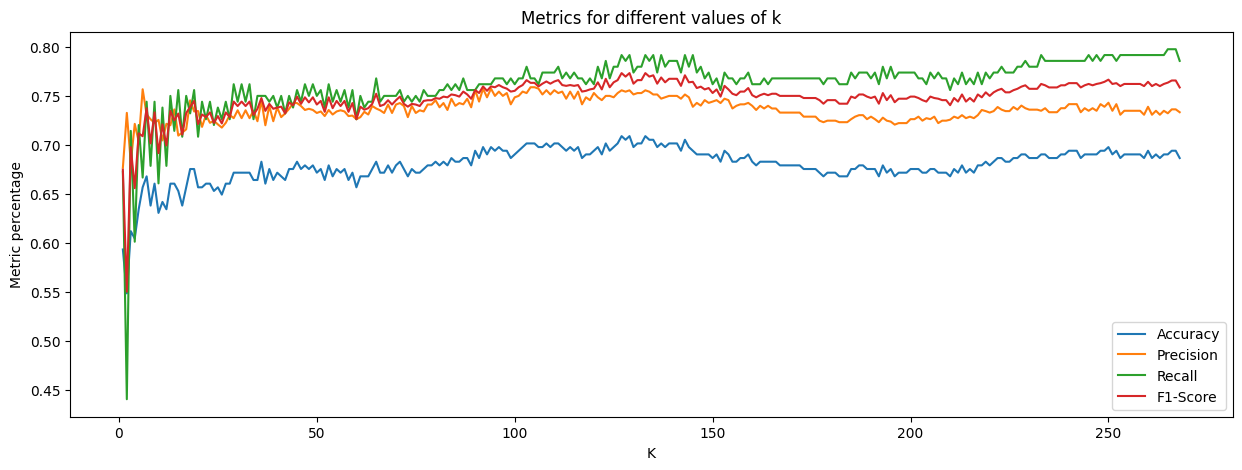

In [124]:
plt.figure(figsize=(15, 5))
plt.title('Metrics for different values of k')
plt.xlabel('K')
plt.ylabel('Metric percentage')
plt.plot(range(1, len(test) + 1), accuracies, label='Accuracy')
plt.plot(range(1, len(test) + 1), precisions, label='Precision')
plt.plot(range(1, len(test) + 1), recalls, label='Recall')
plt.plot(range(1, len(test) + 1), f1_scores, label='F1-Score')
plt.legend()
plt.show()

Para analisar os resultados, foi necessário definir um valor para K. O plot acima mostra os diferentes comportamentos das métricas obtidos para K em todos os tamanhos possíveis para o conjunto de testes. É possível observar que as métricas oscilam frequentemente de acordo com K, fazendo com que seja necessário definir um valor para K ótimo. Para isso, foi utilizado o GridSearchCV, que é uma classe de scikit-learn a qual busca pelo valor ótimo de K avaliando todas as possibilidades, escolhendo aquela com menor erro. O limite de K foi definido como 250 para evitar underfitting.

In [125]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
k_values = [2, 10, 50]

parameters = {"n_neighbors": range(10, 250)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(train_X, train_y)
k_values.append(gridsearch.best_params_['n_neighbors'])
print(f"Best K: {gridsearch.best_params_['n_neighbors']}")


for k in k_values:
    print(f'========================== \n\nK = {k}\n')
    classification = classify_knn(k, train_X, test_X, train_y)
    accuracy, precision, recall, f1_score = obtain_metrics(classification, test_y)
    print(f"Accuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall},\nF1-Score: {f1_score}", end='\n\n')
    print(f"Confusion Matrix: \n{confusion_matrix(classification, test_y)}", end='\n\n')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)


Best K: 201

K = 2

Accuracy: 0.5485074626865671,
Precision: 0.7326732673267327,
Recall: 0.44047619047619047,
F1-Score: 0.550185873605948

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)               74               94
Target 5 Yrs(-)               27               73


K = 10

Accuracy: 0.6305970149253731,
Precision: 0.7254901960784313,
Recall: 0.6607142857142857,
F1-Score: 0.6915887850467289

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              111               57
Target 5 Yrs(-)               42               58


K = 50

Accuracy: 0.6716417910447762,
Precision: 0.7325581395348837,
Recall: 0.75,
F1-Score: 0.7411764705882353

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              126               42
Target 5 Yrs(-)               46               54


K = 201

Accuracy: 0.6753731343283582,
Precision: 0.7262569832402235,
Recall: 0.7738095238095238,
F1-Score: 

#### K = 2
É notável que o modelo apresenta overfitting, tendo o menor número de falsos positivos observados, porém a maior taxa de falsos negativos. Um valor baixo de K resultou em métricas muito negativas, demosntrando dificuldade de generalização no conjunto de testes. O modelo tende a prever melhor a classe negativa.
#### K = 10
Um valor de K maior melhora a acurácia e o recall, mantendo uma boa precisão. O modelo parece mais equilibrado na predição de ambas as classes, porém as métricas ainda se encontram distante do cenário ideal. O número de verdadeiros e falsos positivos aumentou drasticamente. Falsos e verdadeiros negativos diminuíram.
#### K = 50
O modelo parece mais equilibrado na predição de ambas as classes, com recall e f1-score consderavelmente melhores. Ele demonstra uma maior capacidade de generalização, já alcançando o melhor valor de verdadeiros positivos dentre os valores de K testados.
#### K = 201
O melhor valor de K encontrado com limite de 250 foi 201. Ele, no entanto tem menor precisão que o K, porém maior recall. O modelo parece mais equilibrado na predição de ambas as classes, com recall e f1-score levemente melhores. Ele alcança o melhor valor de verdadeiros positivos dentre os valores de K testados.

## Extra - KNN com scikit-learn

In [126]:
accuracies_sklearn = []
precisions_sklearn = []
recalls_sklearn = []
f1_scores_sklearn = []


for k in k_values:
    print(f'========================== \n\nK = {k}\n')
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(train_X, train_y)  # Train the KNN classifier using the train data
    predictions = knn.predict(test_X)  # Make predictions on the test data

    accuracy, precision, recall, f1_score = obtain_metrics(predictions, test_y)
    print(f"Accuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall},\nF1-Score: {f1_score}", end='\n\n')
    print(f"Confusion Matrix: \n{confusion_matrix(predictions, test_y)}", end='\n\n')

    accuracies_sklearn.append(accuracy)
    precisions_sklearn.append(precision)
    recalls_sklearn.append(recall)
    f1_scores_sklearn.append(f1_score)


K = 2

Accuracy: 0.5522388059701493,
Precision: 0.7352941176470589,
Recall: 0.44642857142857145,
F1-Score: 0.5555555555555557

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)               75               93
Target 5 Yrs(-)               27               73


K = 10

Accuracy: 0.6305970149253731,
Precision: 0.7254901960784313,
Recall: 0.6607142857142857,
F1-Score: 0.6915887850467289

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              111               57
Target 5 Yrs(-)               42               58


K = 50

Accuracy: 0.6716417910447762,
Precision: 0.7325581395348837,
Recall: 0.75,
F1-Score: 0.7411764705882353

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              126               42
Target 5 Yrs(-)               46               54


K = 201

Accuracy: 0.6753731343283582,
Precision: 0.7262569832402235,
Recall: 0.7738095238095238,
F1-Score: 0.749279538

## Análise dos Resultados
O Plot abaixo evidencia uma grande similaridade entre a implementação própria e a do scikit-learn. Pode-se observar uma tendência geral  de estabilização entre K = 50 e 201, o melhor valor de K encontrado, para as métricas observadas, evidenciando que aumentar o número de vizinhos drasticamente não necessariamente melhora o modelo. 

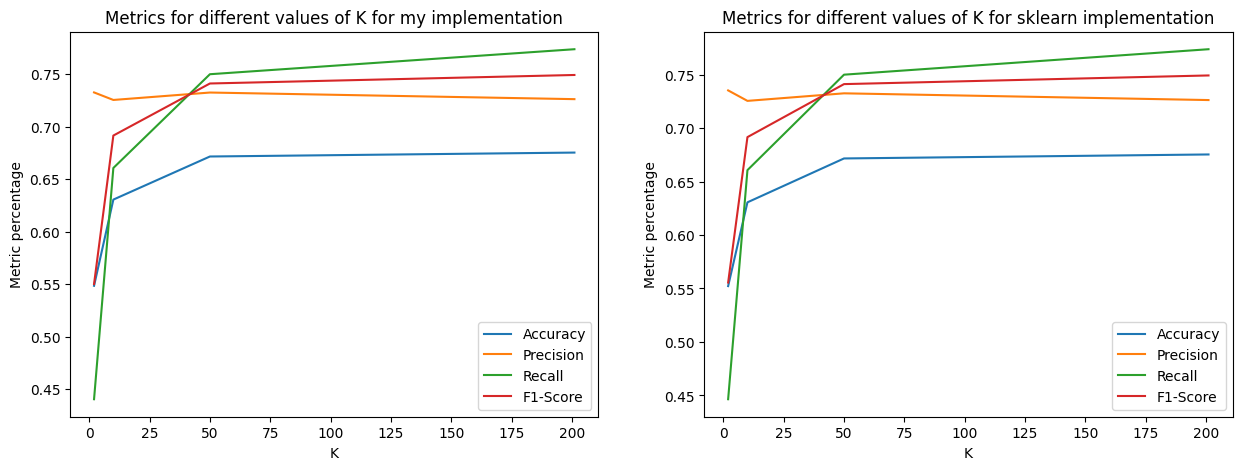

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Metrics for different values of K for my implementation')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Metric percentage')

axes[0].plot(k_values, accuracies, label='Accuracy')
axes[0].plot(k_values, precisions, label='Precision')
axes[0].plot(k_values, recalls, label='Recall')
axes[0].plot(k_values, f1_scores, label='F1-Score')

axes[1].set_title('Metrics for different values of K for sklearn implementation')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Metric percentage')

axes[1].plot(k_values, accuracies_sklearn, label='Accuracy')
axes[1].plot(k_values, precisions_sklearn, label='Precision')
axes[1].plot(k_values, recalls_sklearn, label='Recall')
axes[1].plot(k_values, f1_scores_sklearn, label='F1-Score')

axes[0].legend()
axes[1].legend()
plt.show()

# Aprendizado não supervisionado
## K-Means
O K-Means é um algoritmo de aprendizado não supervisionado baseado na distância dos dados com relação a centroides. Ele inicia escolhendo K centroides aleatórios e, em seguida, atribui cada dado ao centroide mais próximo. Após isso, os centroides são recalculados a partir do ponto médio dos grupos e os dados são novamente atribuídos aos mais próximos. Esse processo é repetido iterativamente até que os centroides não se movam mais.

### A importância de K
O valor de K aqui também é um parâmetro que deve ser definido considerando as particularidades de cada dataset. Ele é responsável por definir a quantidade de centroides que serão utilizados para a clusterização. Números altos levam a grupos mais homogêneos entre si e com valores de pontos internos muito próximos.

Neste caso, deseja-se que a média das distâncias dentro de um mesmo grupo seja baixa e que entre grupos seja a mais alta possível. 

In [128]:
class K_Means:
    def __init__(self, K):
        self.K = K

    def fit(self, X:pandas.DataFrame):
        """
        Fits the K-Means model to the data.

        Parameters
        ----------
        X : pandas DataFrame
            Data to fit the model.
        """
        # Initialize centroids randomly
        self.centroids = [X.iloc[index] for index in np.random.choice(X.shape[0], self.K, replace=False)]
        X = X.values

        while True:
            # Assign labels based on closest centroid
            distances = np.sqrt(((X[:, np.newaxis] - np.array(self.centroids)) ** 2).sum(axis=2))
            labels = np.argmin(distances, axis=1)

            # Find new centroids from means of points
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.K)])

            # Check for convergence
            if np.all(self.centroids == new_centroids):
                break
            else:
                self.centroids = new_centroids

    def predict(self, X):
        """
        Predicts the labels of a dataset.

        Parameters
        ----------
        X : pandas DataFrame
            Data to predict the labels.

        Returns
        -------
        numpy.ndarray
            Labels of the data.
        """
        X = X.values
        distances = np.sqrt(((X[:, np.newaxis] - np.array(self.centroids)) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        return labels

### Análise de Resultados

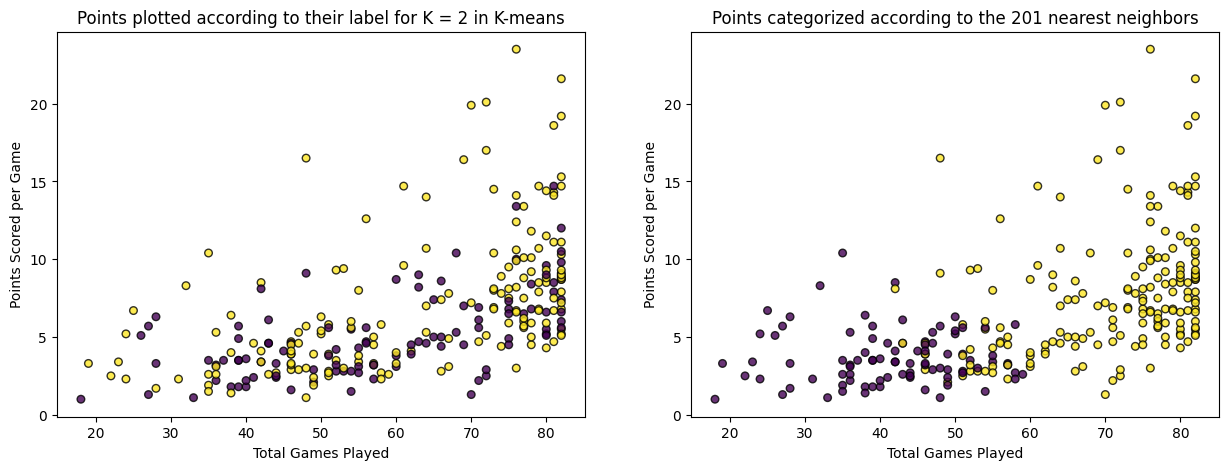

In [129]:
k_means = K_Means(2)
k_means.fit(test_X)
cluster_labels = k_means.predict(test_X)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(test_X.loc[:, "GP"], test_X.loc[:, "PTS"], c=cluster_labels, s=30, cmap='viridis', alpha=0.8, edgecolors='black')
axes[0].set_xlabel('Total Games Played')
axes[0].set_ylabel('Points Scored per Game')
axes[0].set_title('Points plotted according to their label for K = 2 in K-means')

axes[1].scatter(test_X.loc[:, "GP"], test_X.loc[:, "PTS"], c=predictions, s=30, cmap='viridis', alpha=0.8, edgecolors='black')
axes[1].set_xlabel('Total Games Played')
axes[1].set_ylabel('Points Scored per Game')
axes[1].set_title('Points categorized according to the 201 nearest neighbors')

plt.show()

Quando se tem K = 2, a clusterização apresenta um comportamento muito semelhante ao observado na classificação com KNN. Salvos os casos de falsos positivos e negativos, é possível dizer que o uso de duas centroides é capaz de separar os dados de forma satisfatória, indicando com certa precisão aqueles que ficaram na liga por pelo menos 5 anos, tal como é feito no aprendixado supervisionado.

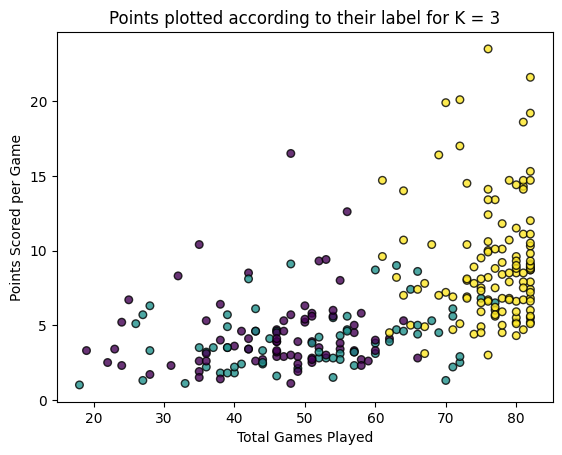

In [130]:
k_means = K_Means(3)
k_means.fit(test_X)
cluster_labels = k_means.predict(test_X)

plt.scatter(test_X.loc[:, "GP"], test_X.loc[:, "PTS"], c=cluster_labels, s=30, cmap='viridis', alpha=0.8, edgecolors='black')
plt.xlabel('Total Games Played')
plt.ylabel('Points Scored per Game')
plt.title('Points plotted according to their label for K = 3')

plt.show()

Para k = 3, é possível observar sobreposição entre os grupos. Estes, portanto, tendem a ser menos distintos entre si. Os membros de um mesmo cluster tendem também a ser mais próximos entre si, tornando a clusterização mais homogênea e menos precisa para se obter características ou insights precisos sobre os dados. Neste caso fica difícil entender a classificação daqueles rookies que ficaram por mais de 5 anos na liga.

## Extra - K-Means com scikit-learn

/home/thiago/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/thiago/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


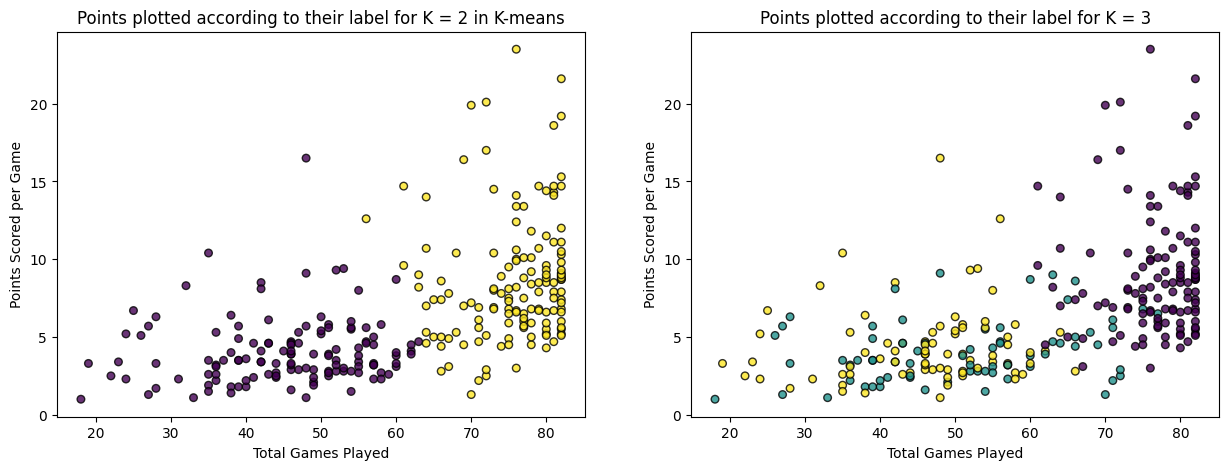

In [131]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(test_X)
cluster_labels = kmeans.predict(test_X)  # Predict the cluster labels for the data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(test_X.loc[:, "GP"], test_X.loc[:, "PTS"], c=cluster_labels, s=30, cmap='viridis', alpha=0.8, edgecolors='black')
axes[0].set_xlabel('Total Games Played')
axes[0].set_ylabel('Points Scored per Game')
axes[0].set_title('Points plotted according to their label for K = 2 in K-means')

kmeans = KMeans(n_clusters=3)
kmeans.fit(test_X)
cluster_labels = kmeans.predict(test_X)  # Predict the cluster labels for the data

axes[1].scatter(test_X.loc[:, "GP"], test_X.loc[:, "PTS"], c=cluster_labels, s=30, cmap='viridis', alpha=0.8, edgecolors='black')
axes[1].set_xlabel('Total Games Played')
axes[1].set_ylabel('Points Scored per Game')
axes[1].set_title('Points plotted according to their label for K = 3')

plt.show()

## Análise dos Resultados
Assim como observado anteriormente, ambos os modelos apresentam resultados muito semelhantes. As diferenças podem ser dadas pela presença do parâmetro n_init na implementação do scikit-learn, que define o número de vezes que o algoritmo será executado com diferentes centroides iniciais. O valor padrão é 10, enquanto na implementação própria foi utilizado apenas 1. Isso pode levar a resultados diferentes, já que o algoritmo é sensível à inicialização dos centroides.

### Referências
https://realpython.com/knn-python/#plotting-the-fit-of-your-model
https://realpython.com/k-means-clustering-python/
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html